## 목표
- 네이버 영화 리뷰의 긍정, 부정을 예측하는 순환 신경망 모델을 만들어보자!
- 학습용 데이터가 아닌 실제 리뷰(텍스트) 데이터를 전처리해서 신경망에 넣어보자!

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
!pip install konlpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.4/19.4 MB 59.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.3/465.3 kB 45.9 MB/s eta 0:00:00


In [3]:
%cd /content/drive/MyDrive/Colab Notebooks/SW캠프_데이터 비즈니스 과정

/content/drive/MyDrive/Colab Notebooks/SW캠프_데이터 비즈니스 과정


In [5]:
df_train = pd.read_csv('data/ratings_train.txt', delimiter = '\t')
df_test = pd.read_csv('data/ratings_test.txt', delimiter = '\t')

In [6]:
df_train

id                                           document  label
0        9976970                                아 더빙.. 진짜 짜증나네요 목소리      0
1        3819312                  흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나      1
2       10265843                                  너무재밓었다그래서보는것을추천한다      0
3        9045019                      교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정      0
4        6483659  사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...      1
...          ...                                                ...    ...
149995   6222902                                인간이 문제지.. 소는 뭔죄인가..      0
149996   8549745                                      평점이 너무 낮아서...      1
149997   9311800                    이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?      0
149998   2376369                        청춘 영화의 최고봉.방황과 우울했던 날들의 자화상      1
149999   9619869                           한국 영화 최초로 수간하는 내용이 담긴 영화      0

[150000 rows x 3 columns]

In [7]:
df_test

id                                           document  label
0      6270596                                                굳 ㅋ      1
1      9274899                               GDNTOPCLASSINTHECLUB      0
2      8544678             뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아      0
3      6825595                   지루하지는 않은데 완전 막장임... 돈주고 보기에는....      0
4      6723715  3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??      0
...        ...                                                ...    ...
49995  4608761          오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함      1
49996  5308387       의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO      0
49997  9072549                 그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다      0
49998  5802125     절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네      0
49999  6070594                                         마무리는 또 왜이래      0

[50000 rows x 3 columns]

In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


In [9]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        50000 non-null  int64 
 1   document  49997 non-null  object
 2   label     50000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.1+ MB


In [10]:
# 결측치가 존재하는 행 제거
df_train.dropna(inplace = True)
df_test.dropna(inplace = True)

In [11]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149995 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        149995 non-null  int64 
 1   document  149995 non-null  object
 2   label     149995 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.6+ MB


- 문제, 정답 데이터로 분리

In [12]:
# id 컬럼은 분석에 큰 영향이 없을 것 같으니 제외
X_train = df_train['document']
y_train = df_train['label']
X_test = df_test['document']
y_test = df_test['label']

In [13]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(149995,)
(149995,)
(49997,)
(49997,)


### konlpy의 형태소 분석기(문장을 형태소로 분리해주는 도구) 종류
- Kkma : 서울대학교 데이터 랩에서 개발, 일반적인 성능은 좋으나 분석시간이 konlpy 형태소 분석기 중 가장 오래 걸림
- Okt : twitter에서 개발, twitter 데이터를 기반으로 형태소를 추출하기 때문에 인터넷 텍스트에 특화되어 있고, 비표준어/ 비속어 등이 포함되어 있는 정제되지 않은 데이터 처리에 강함 + 추가로 konlpy 형태소 분석기 중 유일하게 stemming(어간추출) 기능을 포함하고 있음, 속도는 준수하나 동음이의 처리가 어렵고, 분석 범주가 다른 형태소 분석기에 비해 좁은 단점
- Komoran : Shineware에서 개발, 오탈자에 대해 분석 품질은 좋으나 띄어쓰기가 없는 문장을 분석하는데 좋지 않음
- Hannanum : KAIST에서 개발, 띄어쓰기가 없는 문장에서 분석 품질이 좋지 않음
- Mecab : 일본어용 형태소 분석기를 한국어에 사용할 수 있도록 수정한 분석기, 속도가 5개 중 가장 빠르나 window에서 설치가 힘들고 동음이의어 처리에 취약

위 다섯개 형태소 분석기 모두 nouns, morphs, pos 함수를 지원
- nouns : 주어진 문장의 명사를 추출
- morphs : 주어진 문장의 형태소를 추출
- pos : 주어진 문장의 형태소와 각 단어의 품사를 식별하여 태그를 추가해 함께 출력(품사 태깅)

In [14]:
# 인터넷 영화 리뷰를 분석하는데 적합한 Okt 형태소 분석기 import
from konlpy.tag import Okt
from tqdm import tqdm
import pickle

In [15]:
okt = Okt()

In [16]:
# 형태소 추출 후 공백을 주면서 각각의 문장으로 연결(뒤에 이어질 토큰화에서 공백 기준으로 토큰화)
# 긴 문장이나 띄워쓰기가 잘 되어있지 않은 경우 토큰화의 성능이 좋지 않기 때문에 문장을 형태소로
# 분리한 후 공백을 줘서 다시 문장으로 재구성함!
X_train_morphs = [' '.join(okt.morphs(doc)) for doc in tqdm(X_train)]
X_test_morphs = [' '.join(okt.morphs(doc)) for doc in tqdm(X_test)]

100%|██████████| 49997/49997 [02:13<00:00, 374.24it/s]


In [17]:
X_train_morphs

['아 더빙 .. 진짜 짜증나네요 목소리',
 '흠 ... 포스터 보고 초딩 영화 줄 .... 오버 연기 조차 가볍지 않구나',
 '너 무재 밓었 다그 래서 보는것을 추천 한 다',
 '교도소 이야기 구먼 .. 솔직히 재미 는 없다 .. 평점 조정',
 '사이 몬페 그 의 익살스런 연기 가 돋보였던 영화 ! 스파이더맨 에서 늙어 보이기만 했던 커스틴 던스트 가 너무나도 이뻐 보였다',
 '막 걸음 마 뗀 3 세 부터 초등학교 1 학년 생인 8 살용 영화 . ㅋㅋㅋ ... 별 반개 도 아까 움 .',
 '원작 의 긴장감 을 제대로 살려내지못 했다 .',
 '별 반개 도 아깝다 욕 나온다 이응경 길용우 연 기 생활 이 몇 년 인지 .. 정말 발 로 해도 그것 보단 낫겟다 납치 . 감금 만 반복 반복 .. 이 드라마 는 가족 도 없다 연기 못 하는 사람 만 모 엿 네',
 '액션 이 없는데도 재미 있는 몇 안되는 영화',
 '왜케 평점 이 낮은건데 ? 꽤 볼 만 한 데 .. 헐리우드 식 화려함에만 너무 길들여져 있나 ?',
 '걍 인피니트 가 짱 이다 . 진짜 짱 이다 ♥',
 '볼때 마다 눈물나서 죽겠다 90년 대의 향수 자극 !! 허진호 는 감성 절제 멜로 의 달인 이다 ~',
 '울면 서 손 들 고 횡단보도 건널 때 뛰 쳐나 올 뻔 이범수 연기 드럽게 못 해',
 '담백하고 깔끔해서 좋다 . 신 문 기 사 로만 보다 보면 자꾸 잊어버린다 . 그 들 도 사람 이었다는 것 을 .',
 '취향 은 존중 한 다지 만 진짜 내생 에 극장 에서 본 영화 중 가장 노잼 노 감동 임 스토리 도 어거지 고 감동 도 어거지',
 'ㄱ 냥 매번 긴장 되고 재밋음 ㅠㅠ',
 '참 사람 들 웃긴게 바스코 가 이기 면 락스 코 라고 까고 바비 가 이기 면 아이돌 이라고 깐다 . 그냥 까고싶어서 안달 난 것 처럼 보인다',
 '굿바이 레닌 표절 인 것 은 이해 하는데 왜 뒤 로 갈수록 재미 없어지냐',
 '이건 정말 깨알 캐스팅 과 질퍽 하 지 않은 산뜻한 내 용구성 이 잘 버무러진 깨

In [18]:
# pickle 파일로 저장(colab 재접속 시 바로 가공된 데이터를 사용하기 위함)
# pickle : 텍스트 파일이 아닌 데이터의 자료 구조 형태를 그대로 저장하거나 불러오는 모듈
with open('data/X_train_morphs.pkl', 'wb') as f :
  pickle.dump(X_train_morphs, f)

with open('data/X_test_morphs.pkl', 'wb') as f :
  pickle.dump(X_test_morphs, f)

In [19]:
# pickle 파일 로드(형태소로 분리되어 문장화 되어있는 상태 그대로 로드)
with open('data/X_train_morphs.pkl', 'rb') as f :
  X_train = pickle.load(f)

with open('data/X_test_morphs.pkl', 'rb') as f :
  X_test = pickle.load(f)

### keras에서 지원하는 한글을 포함하는 토크나이저(Tokenizer)를 사용해서 토큰화시켜보자!

- keras 지원 Tokenizer 특징 -
- 1) 공백(띄어쓰기) 기준으로 토큰화
- 2) 빈도수 기준으로 자동 레이블 인코딩(로이터 뉴스 데이터 형태로!)
- 3) 기본적인 한국어 정규표현식이 적용

In [20]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [21]:
tokenizer = Tokenizer()

In [23]:
# 토크나이저로 학습 후 단어사전(BoW) 생성
tokenizer.fit_on_texts(X_train)

In [24]:
# 각 토큰들의 빈도수에 다른 인코딩 결과(랭킹) 출력
tokenizer.word_index

# '이' 라는 토큰이 가장 많이 사용되었으며 1로 인코딩 됨


{'이': 1,
 '영화': 2,
 '의': 3,
 '가': 4,
 '에': 5,
 '을': 6,
 '도': 7,
 '들': 8,
 '는': 9,
 '를': 10,
 '은': 11,
 '너무': 12,
 '한': 13,
 '다': 14,
 '정말': 15,
 '적': 16,
 '만': 17,
 '진짜': 18,
 '점': 19,
 '으로': 20,
 '로': 21,
 '에서': 22,
 '연기': 23,
 '과': 24,
 '평점': 25,
 '것': 26,
 '최고': 27,
 '내': 28,
 '나': 29,
 '그': 30,
 '잘': 31,
 '와': 32,
 '안': 33,
 '인': 34,
 '이런': 35,
 '스토리': 36,
 '생각': 37,
 '못': 38,
 '왜': 39,
 '드라마': 40,
 '1': 41,
 '게': 42,
 '이다': 43,
 '감동': 44,
 '사람': 45,
 '하는': 46,
 '보고': 47,
 '하고': 48,
 '말': 49,
 '고': 50,
 '아': 51,
 '더': 52,
 '때': 53,
 'ㅋㅋ': 54,
 '배우': 55,
 '거': 56,
 '감독': 57,
 '그냥': 58,
 '요': 59,
 '본': 60,
 '재미': 61,
 '내용': 62,
 '뭐': 63,
 '중': 64,
 '까지': 65,
 '좀': 66,
 '쓰레기': 67,
 '보다': 68,
 '없는': 69,
 '시간': 70,
 '수': 71,
 '지': 72,
 '네': 73,
 '10': 74,
 '봤는데': 75,
 '작품': 76,
 '사랑': 77,
 '할': 78,
 '없다': 79,
 '다시': 80,
 '하나': 81,
 '볼': 82,
 '마지막': 83,
 '2': 84,
 '이건': 85,
 'ㅋ': 86,
 '좋은': 87,
 '저': 88,
 '정도': 89,
 '입니다': 90,
 '같은': 91,
 '완전': 92,
 '있는': 93,
 'ㅋㅋㅋ': 94,
 '처음': 95,
 "'":

In [25]:
# 각 토큰이 얼마나 사용되었는지 빈도수 출력
tokenizer.word_counts

OrderedDict([('아', 4373),
             ('더빙', 573),
             ('진짜', 8343),
             ('짜증나네요', 22),
             ('목소리', 375),
             ('흠', 264),
             ('포스터', 573),
             ('보고', 4702),
             ('초딩', 424),
             ('영화', 50737),
             ('줄', 1240),
             ('오버', 142),
             ('연기', 6434),
             ('조차', 242),
             ('가볍지', 26),
             ('않구나', 3),
             ('너', 687),
             ('무재', 69),
             ('밓었', 1),
             ('다그', 24),
             ('래서', 17),
             ('보는것을', 10),
             ('추천', 1193),
             ('한', 11003),
             ('다', 10264),
             ('교도소', 16),
             ('이야기', 2174),
             ('구먼', 11),
             ('솔직히', 1069),
             ('재미', 3930),
             ('는', 17591),
             ('없다', 2868),
             ('평점', 6324),
             ('조정', 40),
             ('사이', 219),
             ('몬페', 2),
             ('그', 5672),
             ('의', 30963),
  

In [26]:
# BoW에 있는 전체 토큰 개수
len(tokenizer.word_index)

102054

### 빈도가 너무 낮은 토큰들은 제거해보자
- 정렬을 이용해서 단어의 빈도수를 확인하고 순위까지 보자!

In [27]:
# 튜플 형태로 보기
tokenizer.word_counts.items()

odict_items([('아', 4373), ('더빙', 573), ('진짜', 8343), ('짜증나네요', 22), ('목소리', 375), ('흠', 264), ('포스터', 573), ('보고', 4702), ('초딩', 424), ('영화', 50737), ('줄', 1240), ('오버', 142), ('연기', 6434), ('조차', 242), ('가볍지', 26), ('않구나', 3), ('너', 687), ('무재', 69), ('밓었', 1), ('다그', 24), ('래서', 17), ('보는것을', 10), ('추천', 1193), ('한', 11003), ('다', 10264), ('교도소', 16), ('이야기', 2174), ('구먼', 11), ('솔직히', 1069), ('재미', 3930), ('는', 17591), ('없다', 2868), ('평점', 6324), ('조정', 40), ('사이', 219), ('몬페', 2), ('그', 5672), ('의', 30963), ('익살스런', 2), ('가', 27571), ('돋보였던', 24), ('스파이더맨', 63), ('에서', 6991), ('늙어', 31), ('보이기만', 1), ('했던', 541), ('커스틴', 4), ('던스트', 2), ('너무나도', 206), ('이뻐', 47), ('보였다', 39), ('막', 330), ('걸음', 20), ('마', 239), ('뗀', 3), ('3', 2380), ('세', 635), ('부터', 1703), ('초등학교', 116), ('1', 5032), ('학년', 122), ('생인', 5), ('8', 736), ('살용', 1), ('ㅋㅋㅋ', 2472), ('별', 2018), ('반개', 212), ('도', 21426), ('아까', 431), ('움', 1063), ('원작', 1252), ('긴장감', 830), ('을', 23237), ('제대로', 799), ('살려내지못', 2), 

In [28]:
df = pd.DataFrame(tokenizer.word_counts.items(),
                  columns = ['Token', 'Count']
                  )
df.head()

Token  Count
0      아   4373
1     더빙    573
2     진짜   8343
3  짜증나네요     22
4    목소리    375

In [31]:
# 정렬 후 출력되는 index는 의미가 없으므로 reset_index로 현재 values 상태 그대로 다시 인덱스를 매겨줌
# 기존 index는 컬럼으로 들어오지만 drop = True 로 없애줌
df_sorted = df.sort_values(by = 'Count', ascending = False).reset_index(drop = True)
df_sorted

Token  Count
0           이  56108
1          영화  50737
2           의  30963
3           가  27571
4           에  26772
...       ...    ...
102049   매조키즘      1
102050  나온거라니      1
102051    맡아던      1
102052    어케해      1
102053     수간      1

[102054 rows x 2 columns]

In [32]:
# 등장 빈도가 20번 미만인 데이터를 제거하자(최소 20번은 나와야 BoW에 저장하기!)
df_sorted[df_sorted['Count'] < 20]

Token  Count
7852    지루하다는     19
7853     상관없이     19
7854       소라     19
7855       아따     19
7856      살아라     19
...       ...    ...
102049   매조키즘      1
102050  나온거라니      1
102051    맡아던      1
102052    어케해      1
102053     수간      1

[94202 rows x 2 columns]

In [33]:
# num_words : 원하는 인덱스 번호까지만 사용(학습 데이터에서 빈도수가 높은 7851개의 데이터만 사용하겠다는 뜻)
final_tokenizer = Tokenizer(num_words = 7851)

In [34]:
final_tokenizer.fit_on_texts(X_train)

In [35]:
# texts_to_sequences : 토큰들을 인코딩 시킨 결과를 순서대로 리스트에 넣어줌
X_train_seq = final_tokenizer.texts_to_sequences(X_train)
X_test_seq = final_tokenizer.texts_to_sequences(X_test)

In [36]:
X_train_seq

# 다만 빈도수가 20회 미만인 데이터는 사용하지 않았기 때문에 단어가 부족한 리스트가 있을 수 있음

[[51, 451, 18, 7034, 659],
 [910, 452, 47, 608, 2, 203, 1582, 23, 986, 6213],
 [376, 2900, 6589, 207, 13, 14],
 [110, 223, 61, 9, 79, 25, 4472],
 [1076, 30, 3, 23, 4, 6590, 2, 3103, 22, 5441, 476, 4, 1127, 3928, 4568],
 [740,
  7539,
  994,
  100,
  404,
  143,
  1899,
  41,
  1798,
  349,
  2,
  94,
  124,
  1100,
  7,
  589,
  228],
 [201, 3, 311, 6, 319, 229],
 [124,
  1100,
  7,
  146,
  328,
  734,
  334,
  127,
  1757,
  1,
  367,
  644,
  212,
  15,
  760,
  21,
  374,
  576,
  504,
  3796,
  17,
  1514,
  1514,
  1,
  40,
  9,
  266,
  7,
  79,
  23,
  38,
  46,
  45,
  17,
  699,
  1135,
  73],
 [98, 1, 61, 93, 367, 411, 2],
 [1704, 25, 1, 527, 82, 17, 13, 395, 1572, 365, 12, 1116],
 [379, 6036, 4, 155, 43, 18, 155, 43, 368],
 [749, 385, 6414, 932, 1128, 3006, 895, 9, 613, 2966, 815, 3, 7279, 43],
 [2645, 130, 867, 8, 50, 53, 4473, 776, 773, 4569, 23, 1506, 38, 177],
 [224, 467, 1300, 127, 735, 1624, 68, 137, 912, 30, 8, 7, 45, 6415, 26, 6],
 [883,
  11,
  4873,
  13,
  17,
  

- 현재까지가 raw 데이터(리뷰 데이터)에서 1) 형태소 추출, 2) 토큰화 + 랭킹 순 인코딩, 3) 빈도수가 적은 단어 제외까지 진행한 상태
- 한국어 같은 경우는 형태소 추출이나 토큰화 단계에서 조사나 접속사를 제거하면 되기 때문에 따로 정해진 불용어가 없음(직접 설정하고 싶다면 불용어 사전을 만들고 기존 데이터에서 not in으로 제거해주면 됨)

### 순환 신경망에 넣기 위해 리뷰 데이터의 시퀀스 길이를 알아보자!

In [37]:
# X_train_seq에 있는 내부 리스트의 개수(시퀀스 길이)를 반환하여 리스트에 저장
X_train_len = [len(doc) for doc in X_train_seq]

In [38]:
X_train_len

[5,
 10,
 6,
 7,
 15,
 17,
 6,
 37,
 7,
 12,
 9,
 14,
 14,
 16,
 25,
 7,
 20,
 12,
 14,
 17,
 15,
 3,
 40,
 8,
 6,
 7,
 4,
 2,
 0,
 12,
 18,
 8,
 6,
 7,
 8,
 5,
 6,
 7,
 8,
 8,
 4,
 24,
 2,
 12,
 29,
 9,
 35,
 16,
 6,
 46,
 17,
 9,
 11,
 13,
 1,
 2,
 1,
 27,
 2,
 2,
 6,
 10,
 6,
 30,
 10,
 44,
 24,
 14,
 12,
 5,
 7,
 29,
 1,
 7,
 4,
 13,
 7,
 2,
 19,
 0,
 9,
 3,
 15,
 5,
 4,
 5,
 2,
 4,
 3,
 6,
 7,
 3,
 3,
 8,
 5,
 6,
 3,
 6,
 5,
 12,
 16,
 9,
 9,
 7,
 5,
 14,
 1,
 4,
 11,
 10,
 12,
 12,
 6,
 1,
 16,
 3,
 5,
 4,
 12,
 4,
 32,
 14,
 10,
 5,
 2,
 6,
 8,
 19,
 47,
 9,
 2,
 4,
 2,
 8,
 6,
 9,
 14,
 5,
 10,
 14,
 0,
 11,
 47,
 2,
 2,
 5,
 39,
 20,
 14,
 45,
 9,
 1,
 12,
 4,
 3,
 2,
 19,
 9,
 5,
 2,
 7,
 14,
 7,
 33,
 52,
 12,
 3,
 12,
 10,
 0,
 29,
 39,
 4,
 4,
 5,
 22,
 5,
 4,
 13,
 4,
 34,
 7,
 36,
 2,
 10,
 1,
 5,
 7,
 21,
 7,
 6,
 12,
 11,
 15,
 16,
 12,
 4,
 19,
 16,
 25,
 9,
 14,
 6,
 52,
 19,
 4,
 9,
 2,
 13,
 6,
 4,
 8,
 8,
 9,
 2,
 10,
 12,
 11,
 11,
 10,
 24,
 6,
 19,
 12,
 6,
 11

In [39]:
print("최대값 : ", max(X_train_len))
print("최소값 : ", min(X_train_len))
print("평균값 : ", np.mean(X_train_len))
print("중앙값 : ", np.median(X_train_len))

# 길이가 0인 리뷰는 빈도수가 20회 미만인 단어들로만 이루어져 있어서 전부 없어짐

최대값 :  77
최소값 :  0
평균값 :  11.362445414847162
중앙값 :  9.0


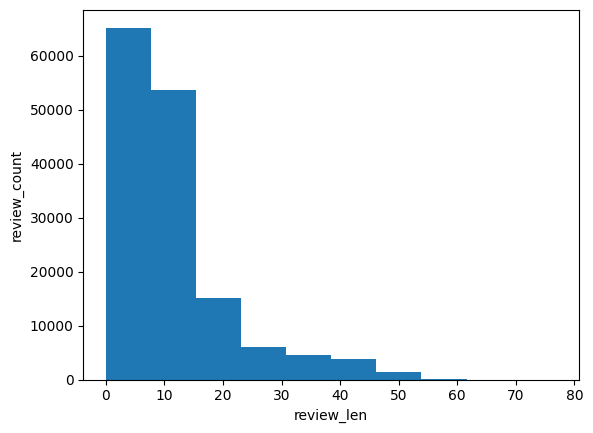

In [40]:
# 히스토그램으로 리뷰 길이의 분포를 확인해보자!
plt.hist(X_train_len, bins = 10)
plt.xlabel('review_len')
plt.ylabel('review_count')
plt.show()

In [41]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

X_train_pad_seq = pad_sequences(X_train_seq, maxlen = 15)
X_test_pad_seq = pad_sequences(X_test_seq, maxlen = 15)

In [42]:
X_train_pad_seq.shape, X_test_pad_seq.shape

((149995, 15), (49997, 15))

### 신경망 모델링
- 입력층에 임베딩 층 설정(input_dim 설정)
- 중간층에 LSTM층
- 출력층에 MLP
- loss, optimizer
- validattion 데이터 분리해서 학습
- modelcheckpoint(모델체크포인트), earlystopping
- 학습 결과 시각화
- test 데이터로 classification_report 출력

In [54]:
from sklearn.metrics import classification_report
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [44]:
save_path = '/content/drive/MyDrive/Colab Notebooks/SW캠프_데이터 비즈니스 과정/model/ReviewModel_{epoch:03d}_{val_acc:.4f}.hdf5'

f_mckp = ModelCheckpoint(filepath = save_path,     # 파일 경로 설정
                         monitor = 'val_acc',      # 해당 값을 기준으로 파일 저장, val_acc 값이 높아져야 저장   ! val_loss의 경우 낮아져야 저장(min)
                         save_best_only = True,    # monitor값이 가장 최고점 혹은 최저점을 갱신했을 경우 모델 저장
                         mode = 'max',       # save_best_only가 True일 경우 갱신 값의 최대, 최소를 결정
                         verbose = 1           # 모델 개선 및 저장 메세지를 출력
                         )

f_early = EarlyStopping(monitor = 'val_acc',
                        # monitor의 값 개선을 몇번이나 기다려줄지를 결정
                        patience = 5
                        )

In [51]:
model = Sequential()

# input_dim : 데이터 내에서 사용할 최대 단어 개수(뉴스 기사는 대부분 1000개 이하의 단어로 구성 되어 있으므로 1000으로 설정)
# output_dim : 임베딩 후 생성된 실수의 개수(하나의 단어를 표현하는 가짓수)
model.add(Embedding(input_dim = 7851, output_dim = 100))

# 학습 시 과대적합을 방지하기 위해 매 epoch마다 랜덤하게 30%의 뉴런들의 학습을 비활성화 시킴
# model.add(Dropout(0.3))

model.add(LSTM(2000, return_sequences = True))
model.add(LSTM(1000))
model.add(Dense(1, activation = 'sigmoid'))

model.compile(loss = 'binary_crossentropy',
              optimizer = 'Adam',
              metrics = ['acc']
              )


h = model.fit(X_train_pad_seq, y_train,
              validation_split = 0.2,
              batch_size = 128,
              epochs = 10,
              callbacks = [f_mckp, f_early]
              )

Epoch 1/10
938/938 [==============================] - ETA: 0s - loss: 0.4109 - acc: 0.8069
Epoch 1: val_acc did not improve from 0.84086
938/938 [==============================] - 127s 131ms/step - loss: 0.4109 - acc: 0.8069 - val_loss: 0.3652 - val_acc: 0.8383
Epoch 2/10
938/938 [==============================] - ETA: 0s - loss: 0.3303 - acc: 0.8521
Epoch 2: val_acc did not improve from 0.84086
938/938 [==============================] - 110s 117ms/step - loss: 0.3303 - acc: 0.8521 - val_loss: 0.3579 - val_acc: 0.8400
Epoch 3/10
938/938 [==============================] - ETA: 0s - loss: 0.2944 - acc: 0.8691
Epoch 3: val_acc did not improve from 0.84086
938/938 [==============================] - 110s 117ms/step - loss: 0.2944 - acc: 0.8691 - val_loss: 0.3712 - val_acc: 0.8391
Epoch 4/10
938/938 [==============================] - ETA: 0s - loss: 0.2623 - acc: 0.8854
Epoch 4: val_acc did not improve from 0.84086
938/938 [==============================] - 109s 117ms/step - loss: 0.2623 - a

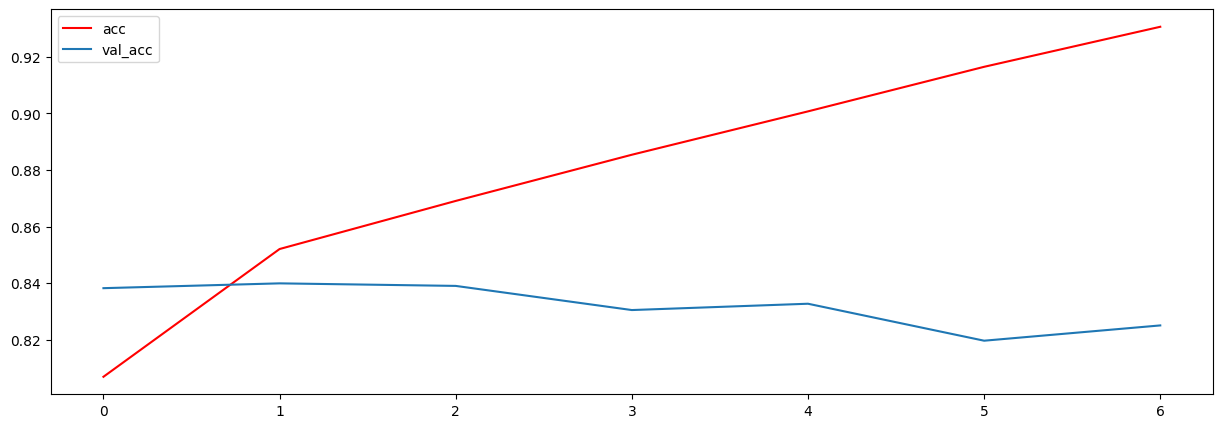

In [52]:
# 3. 시각화
plt.figure(figsize = (15,5))

# train 데이터
plt.plot(h.history['acc'], label = 'acc', color = 'red')
# validation 데이터
plt.plot(h.history['val_acc'], label = 'val_acc')

plt.legend()
plt.show()

In [55]:
model.evaluate(X_test_pad_seq, y_test)

1563/1563 [==============================] - 28s 18ms/step - loss: 0.5715 - acc: 0.8211


[0.5715478658676147, 0.8210892677307129]

In [53]:
pre = model.predict(X_test_pad_seq)
print(classification_report(y_test, np.argmax(pre, axis = 1)))

1563/1563 [==============================] - 25s 16ms/step
              precision    recall  f1-score   support

           0       0.50      1.00      0.66     24826
           1       0.00      0.00      0.00     25171

    accuracy                           0.50     49997
   macro avg       0.25      0.50      0.33     49997
weighted avg       0.25      0.50      0.33     49997



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [2]:
pre = model.predict(X_test_pad_seq)
pre

NameError: ignored

In [1]:
# 이진 분류에서는 출력층 뉴런수가 1개이므로 0 ~ 1 사이 확률값이 하나만 나오는데 이를 0 or 1로 변환시켜줘야 함
# pre 내부 값이 0.5보다 크면 True 출력, 아니면 False가 출력되는데(파이썬에서는 True가 1, False가 0으로 인식) 이를 정수로 변환
pre_binary = (pre > 0.5).astype(int)
pre_binary

NameError: ignored

In [ ]:
print(classification_report(y_test, np.argmax(pre_binary, axis = 1)))